In [1]:
from utils import *
import pandas as pd
import mne
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize, StandardScaler

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5722792/

The frontal asymmetry is most commonly computed by subtracting the natural log of left hemisphere alpha power (EEG electrode F3) from the natural log of right hemisphere alpha power (F4) while using the central Cz as reference electrode

In [2]:
participants = []
pd_raws = []
files = glob(f"data/*.csv")
for index, f in enumerate(files):
    name = f.split('/')[1].split('__')[0]
    # if(name in ['bam','MJ']): continue
    participants.append(name)
    pd_raw = pd.read_csv(f, dtype={'Marker':str})
    pd_raw = pd_raw.drop(columns='timestamps')
    # print(pd_raw.Marker.unique())
    # pd_raw = marker_converter(pd_raw,marker_names)
    print(f"{index} {name} | time: {len(pd_raw)/125}")
    pd_raws.append(pd_raw)
# print(participants)


0 suyo | time: 610.56
1 gon | time: 614.592
2 beau | time: 612.768
3 eiyu | time: 613.056
4 fahmai | time: 609.312
5 nuclear | time: 611.04
6 minkhant | time: 609.312
7 poon | time: 632.64
8 pear | time: 630.816
9 harold | time: 609.312
10 dream | time: 612.0
11 new | time: 609.504
12 sam | time: 609.792
13 pla | time: 610.656
14 miiw | time: 608.832
15 job | time: 609.888
16 yee | time: 623.808
17 tom | time: 612.768
18 fabby | time: 606.816
19 nopphon | time: 615.744
20 bam | time: 355.52
21 aun | time: 609.504
22 prin | time: 610.752
23 film | time: 606.912
24 beer | time: 619.008
25 yong | time: 611.52
26 MJ | time: 476.544
27 nice | time: 611.136
28 bank | time: 609.696
29 shin | time: 611.712
30 dt | time: 611.424
31 flm | time: 602.688
32 bas | time: 608.832
33 kee | time: 614.496
34 aui | time: 611.904
35 kao | time: 613.824
36 nisit | time: 607.584
37 ice | time: 612.864
38 int | time: 611.04
39 taew | time: 641.952
40 noey | time: 612.864
41 por | time: 612.0
42 pang | time: 

In [3]:
raws = []
sampling_rate = 125 # Hz
with tqdm(pd_raws) as pbar:
    for index,pd_raw in enumerate(pbar):
        pbar.set_description(f"{index} {participants[index]}")
        raw = dataframe_to_raw(pd_raw, sfreq=sampling_rate)
        raws.append(raw)

  0%|          | 0/54 [00:00<?, ?it/s]

In [4]:
del(pd_raws)

0 suyo


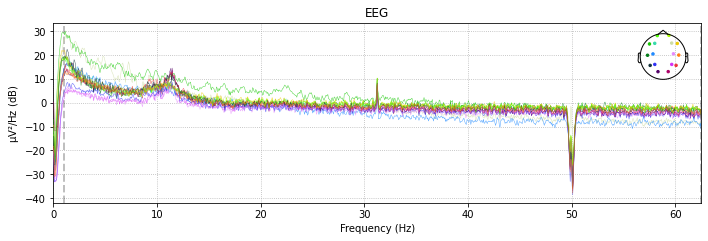

1 gon


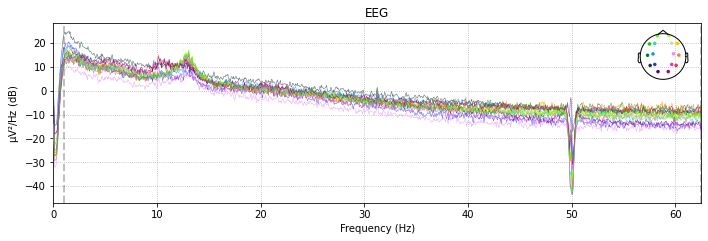

2 beau


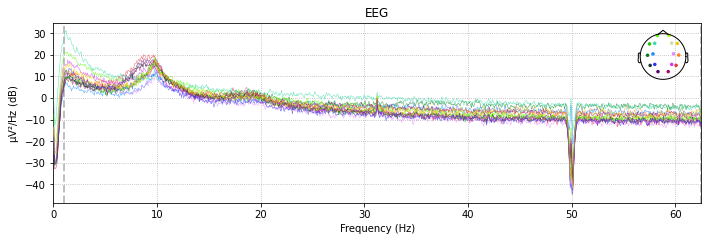

3 eiyu


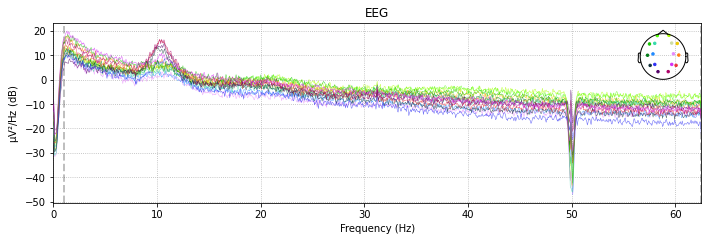

4 fahmai


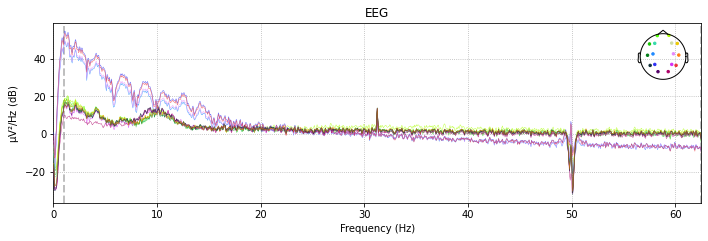

5 nuclear


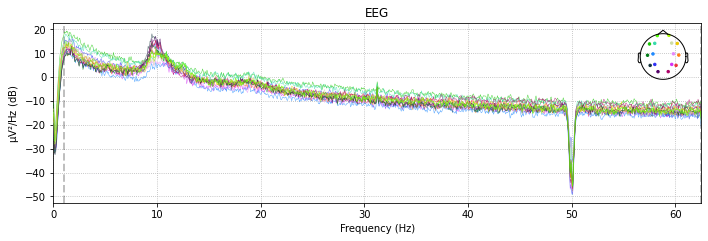

6 minkhant


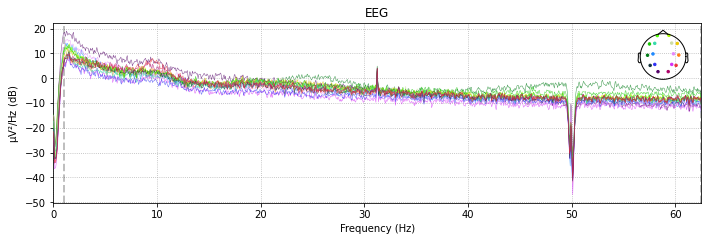

7 poon


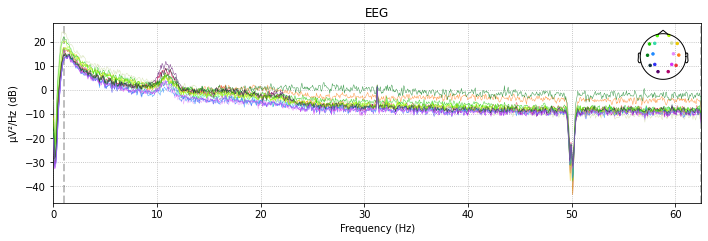

8 pear


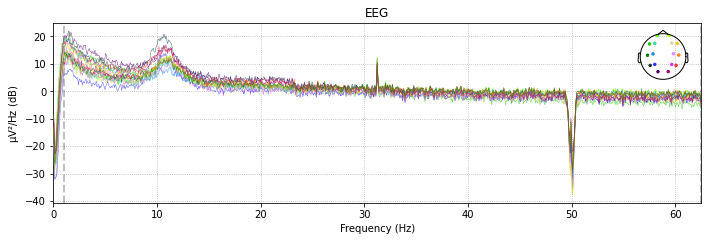

9 harold


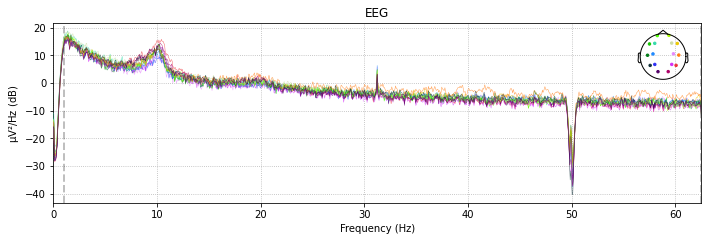

10 dream


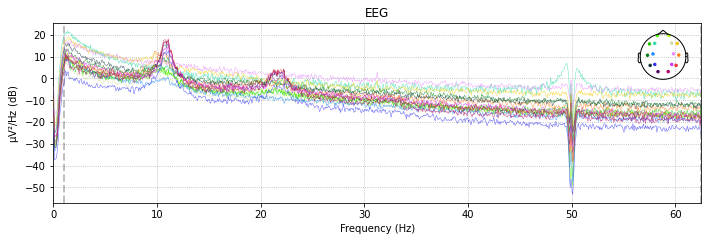

11 new


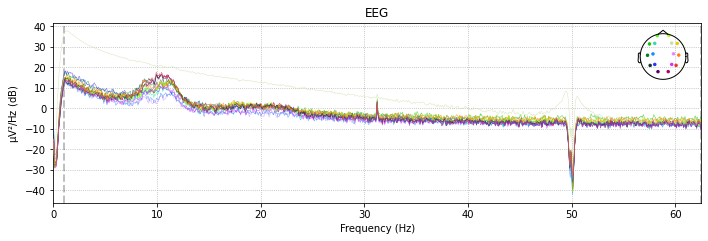

12 sam


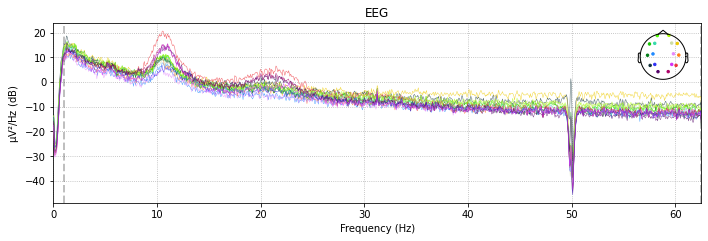

13 pla


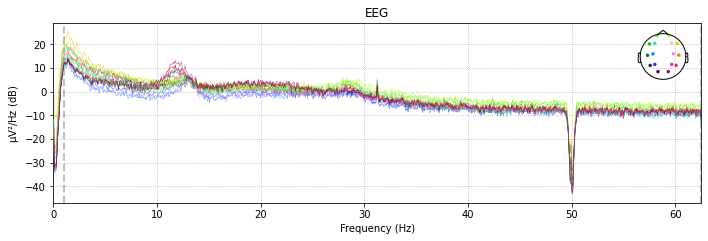

14 miiw


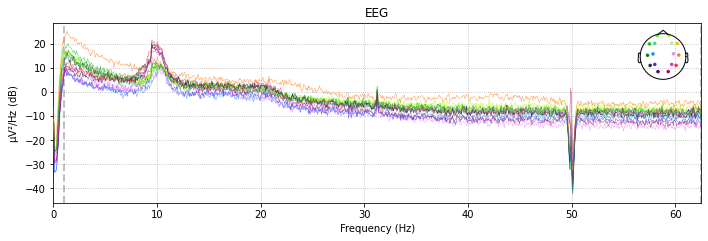

15 job


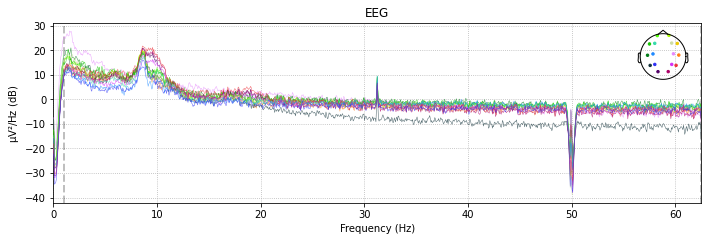

16 yee


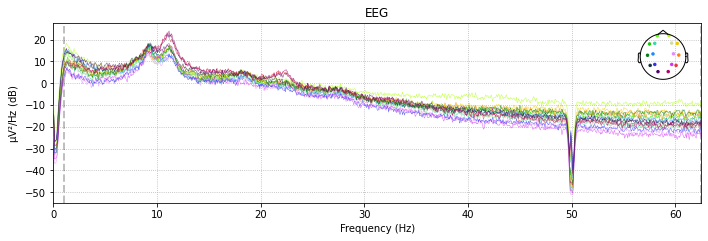

17 tom


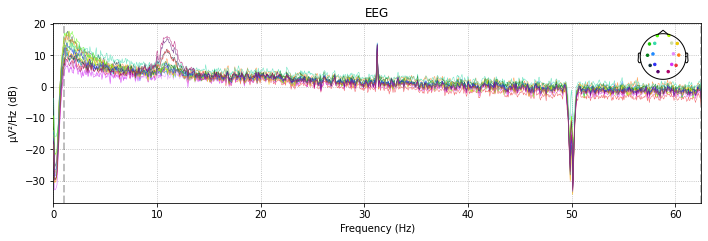

18 fabby


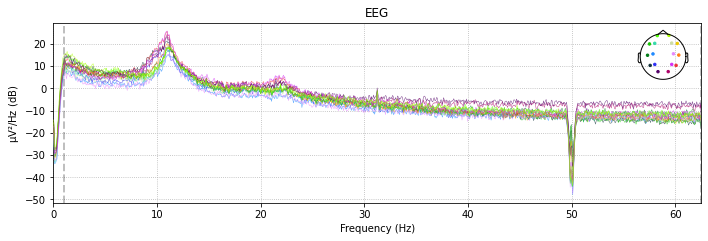

19 nopphon


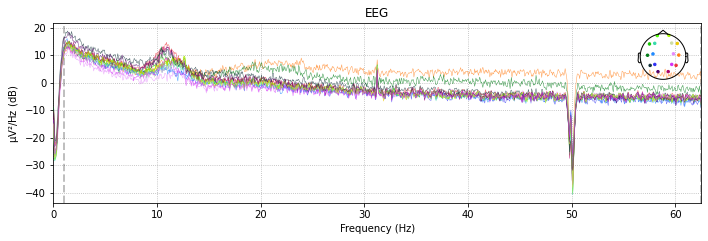

20 bam


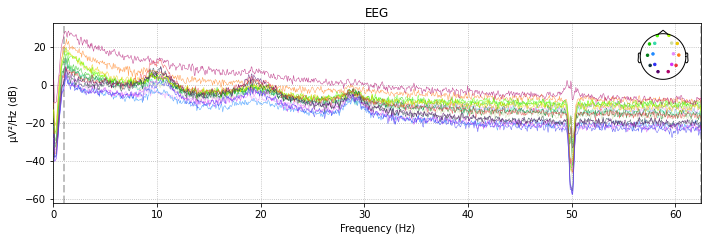

21 aun


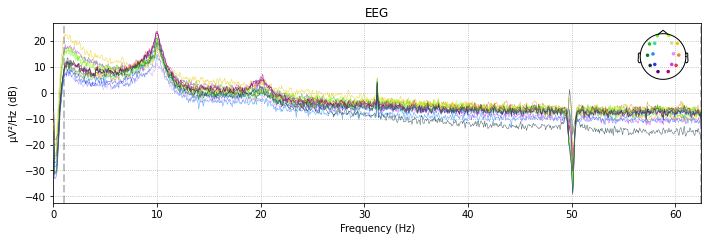

22 prin


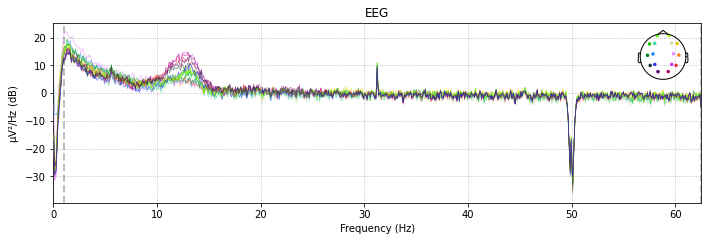

23 film


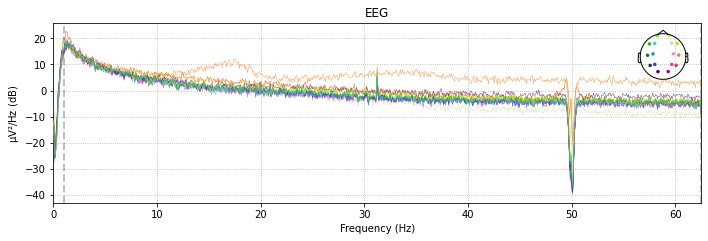

24 beer


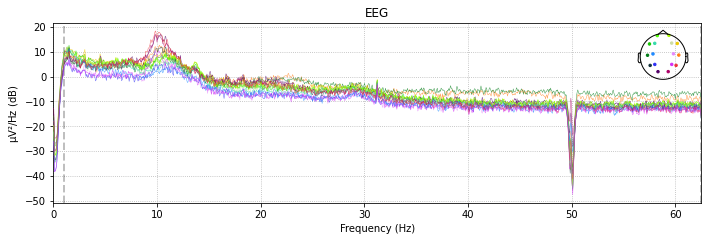

25 yong


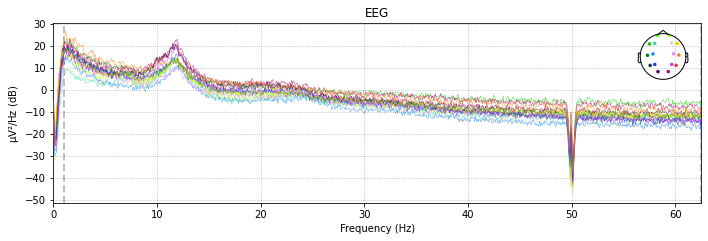

26 MJ


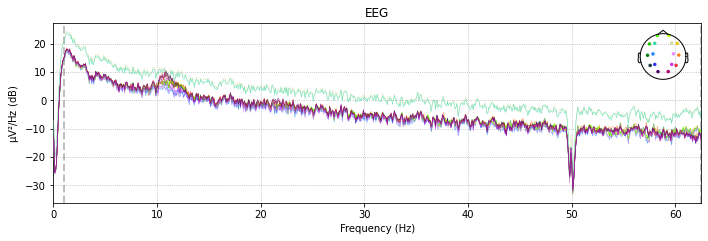

27 nice


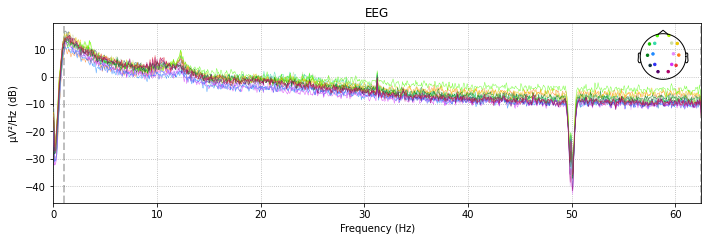

28 bank


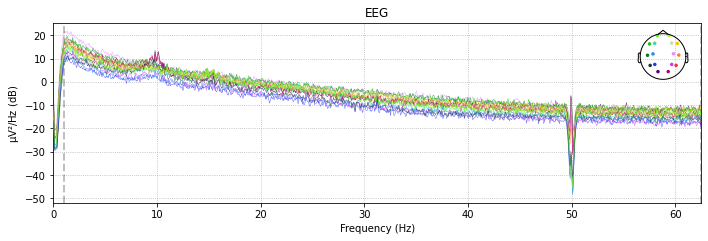

29 shin


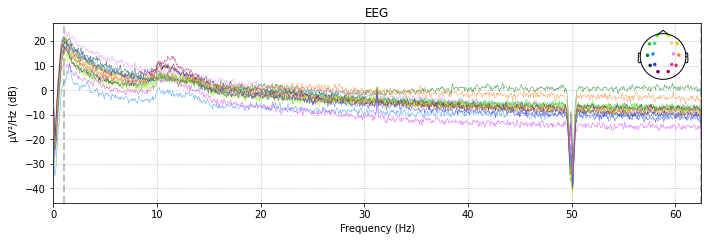

30 dt


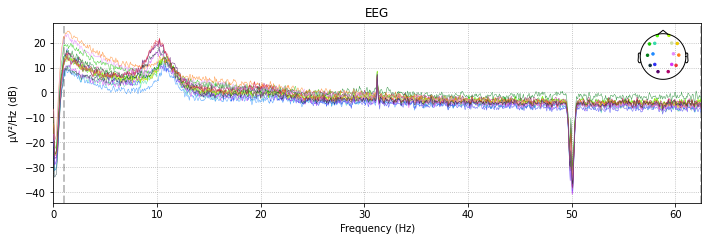

31 flm


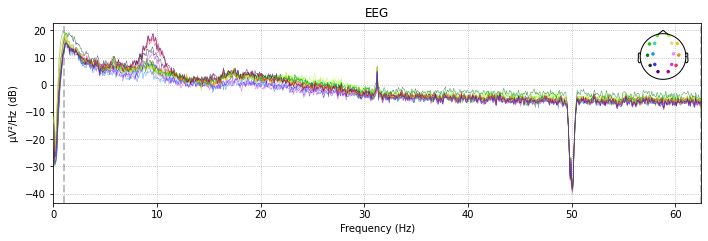

32 bas


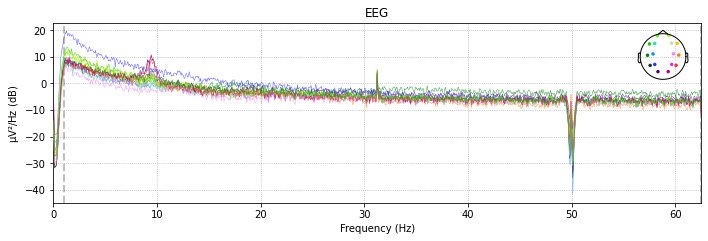

33 kee


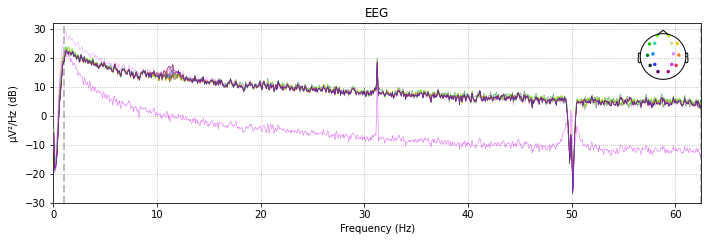

34 aui


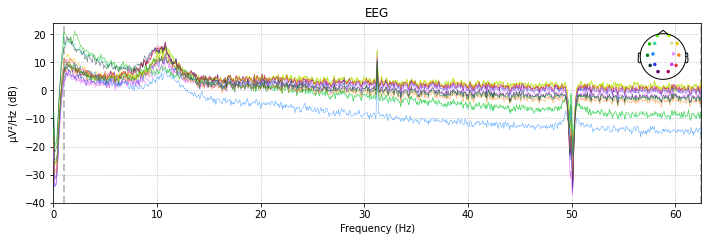

35 kao


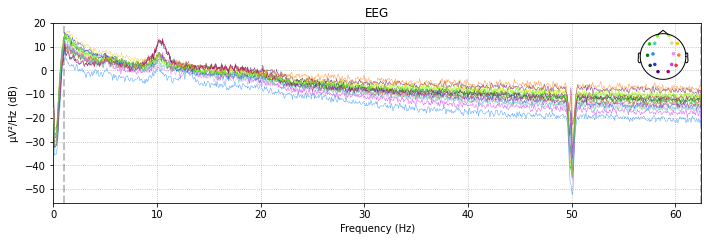

36 nisit


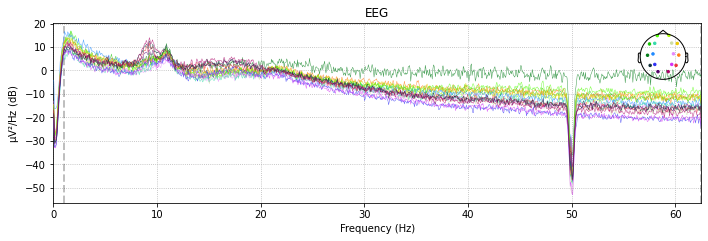

37 ice


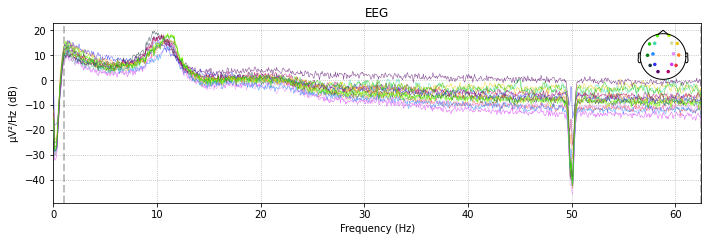

38 int


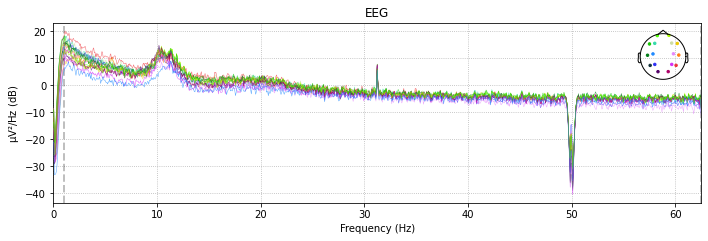

39 taew


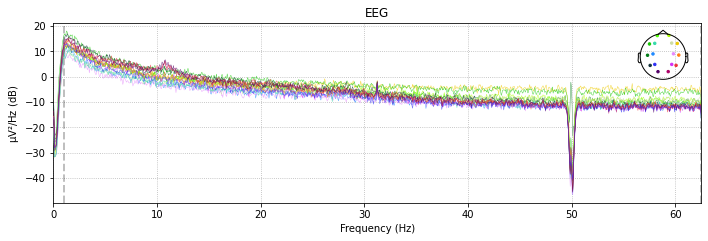

40 noey


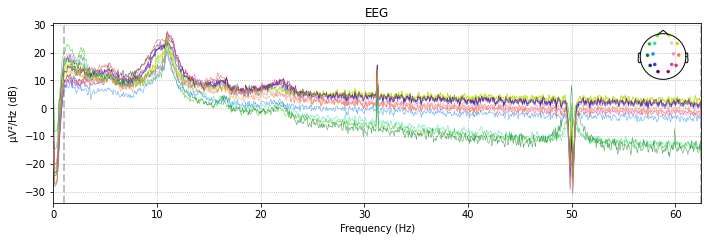

41 por


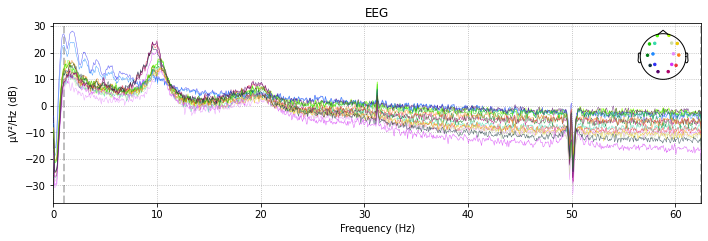

42 pang


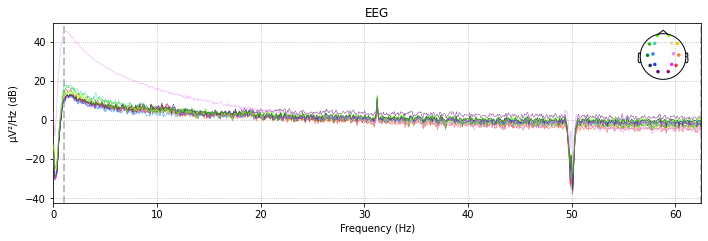

43 satya


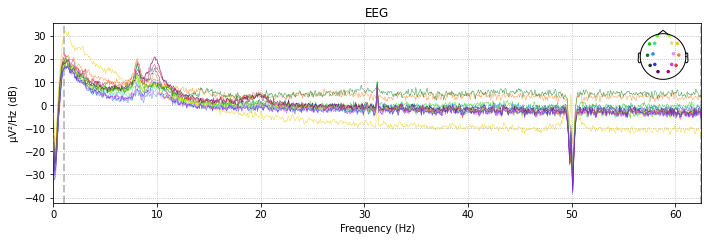

44 boss


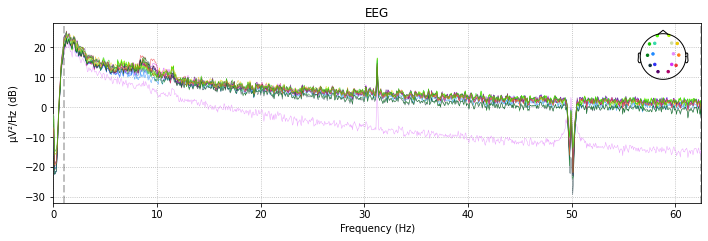

45 s


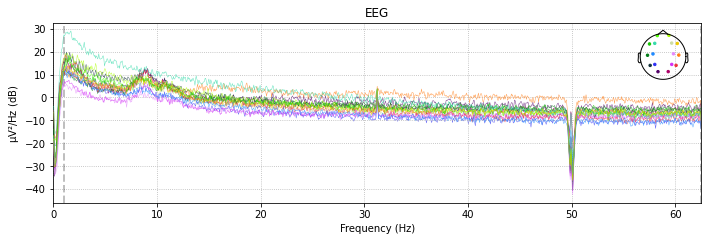

46 praewphan


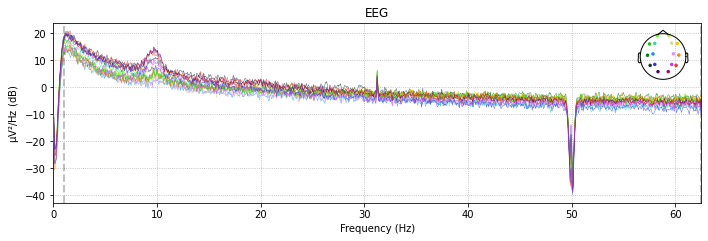

47 mind


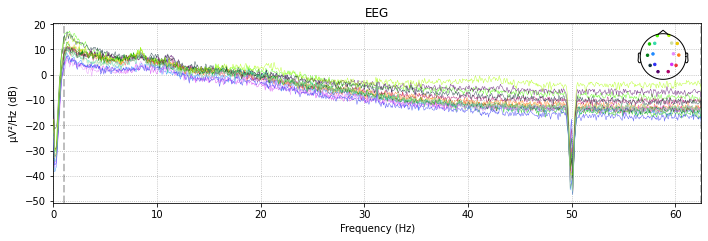

48 ploy


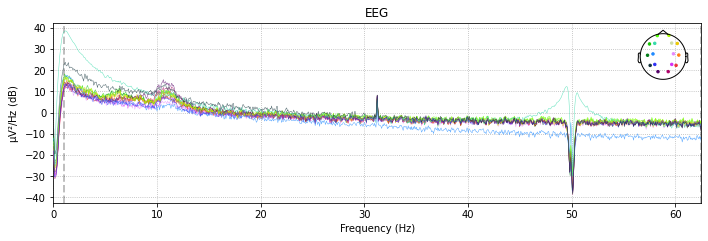

49 cedric


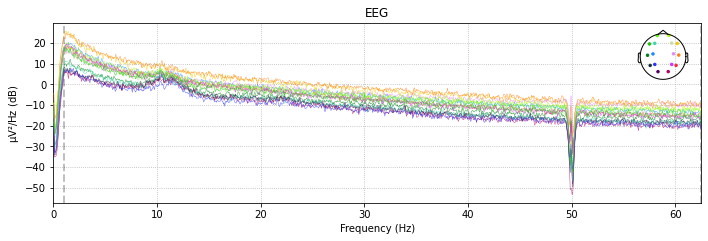

50 kant


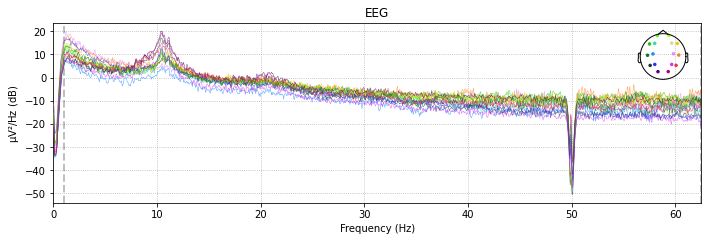

51 mu


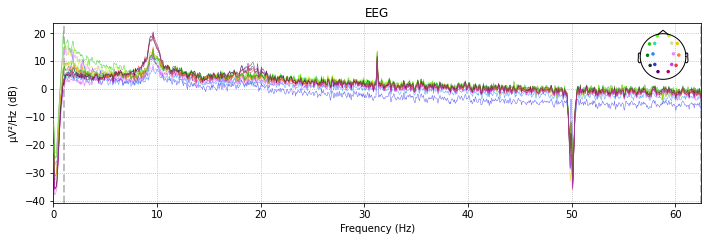

52 younten


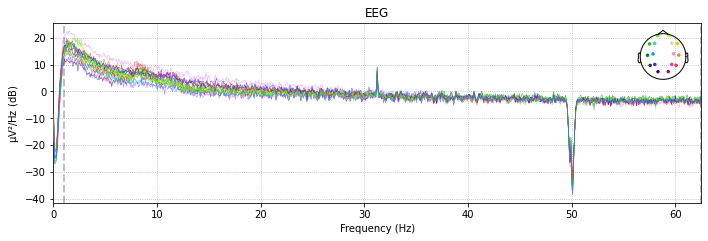

53 amp


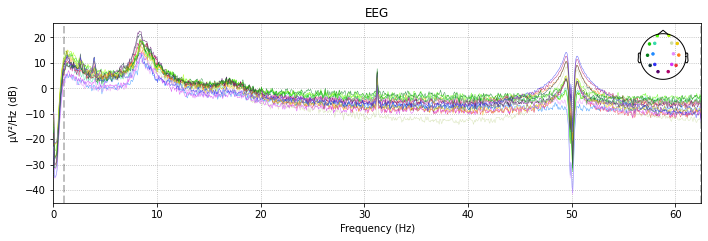

In [5]:
for index,raw in enumerate(raws):
    print(index, participants[index])
    raw.filter(l_freq=1,h_freq=None, method='iir', iir_params={'order':3.0, 'ftype':'butter'}, verbose=False) # Slow drift
    raw.notch_filter(freqs=[50])
    raw.plot_psd()

In [6]:
raw = raws[participants.index('amp')]
power,freq = mne.time_frequency.psd_welch(raw,n_fft=125, verbose=True)

Effective window size : 1.000 (s)


In [7]:
band_names = np.array(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'Slow', 'Low_beta'])
filter_list = [[1,3],[4,7],[8,12],[13,30],[30,43], [4,13], [13,17]]
bands = []
for filt in filter_list:
    pt = np.argwhere((freq >= filt[0]) & (freq <= filt[1])).reshape(-1)
    bands.append(pt)
bands = np.array(bands)
print(bands)

[array([1, 2, 3]) array([4, 5, 6, 7]) array([ 8,  9, 10, 11, 12])
 array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
        30])
 array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43])
 array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
 array([13, 14, 15, 16, 17])]


<ipython-input-7-3759ae126e95>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bands = np.array(bands)


In [8]:
features = None
for raw in raws:
    feature = None
    slow, gamma = None, None
    a_f3, a_f4 = None, None
    a_t7, a_t8 = None, None
    b_f3, b_f4 = None, None
    b_t7, b_t8 = None, None
    for index, band in enumerate(bands):
        power,freq = mne.time_frequency.psd_welch(raw,n_fft=125, verbose=False)
        power = 10 * np.log10(power)
        data = power[::,band].mean(axis=1).reshape(1,-1)
        # for asym
        if(band_names[index] == 'Alpha'):
            a_f3 = data[:,raw.ch_names.index('F3')]
            a_f4 = data[:,raw.ch_names.index('F4')]
            # We use t3 as t7 and t4 as t8
            a_t7 = data[:,raw.ch_names.index('T3')]
            a_t8 = data[:,raw.ch_names.index('T4')]
        if(band_names[index] == 'Beta'):
            b_f3 = data[:,raw.ch_names.index('F3')]
            b_f4 = data[:,raw.ch_names.index('F4')]
            # We use t3 as t7 and t4 as t8
            b_t7 = data[:,raw.ch_names.index('T3')]
            b_t8 = data[:,raw.ch_names.index('T4')]

        ####### Mean for visualization #######
        data = data.mean().reshape(1,-1)
        # for relative gamma
        if(band_names[index] == 'Slow'): slow = data
        if(band_names[index] == 'Gamma'): gamma = data

        if(type(feature) == type(None)): feature = data
        else: feature = np.concatenate([feature, data], axis=1)
    # print(feature.shape)
    # the eighth feature: relative gamma is slow/gamma
    relative_gamma = slow/gamma
    feature = np.concatenate([feature, relative_gamma], axis=1)
    # The asymetry
    alpha_frontal = ((a_f4 - a_f3) / (a_f4 + a_f3)).reshape(1,-1)
    feature = np.concatenate([feature, alpha_frontal], axis=1)
    # alpha_temporal
    alpha_temporal = ((a_t8 - a_t7) / (a_t8 + a_t7)).reshape(1,-1)
    feature = np.concatenate([feature, alpha_temporal], axis=1)
    # alpha_asymmetry
    alpha_asymmetry = alpha_frontal + alpha_temporal
    feature = np.concatenate([feature, alpha_asymmetry], axis=1)
    # beta_frontal
    beta_frontal = ((b_f4 - b_f3) / (b_f4 + b_f3)).reshape(1,-1)
    feature = np.concatenate([feature, beta_frontal], axis=1)
    # beta_temporal
    beta_temporal = ((b_t8 - b_t7) / (b_t8 + b_t7)).reshape(1,-1)
    feature = np.concatenate([feature, beta_temporal], axis=1)

    # print(slow/gamma)
    # print(feature.shape)
    # print(feature)
    if(type(features) == type(None)): features = feature
    else: features = np.concatenate([features, feature], axis=0)
print(features.shape)


(54, 13)


In [9]:
print(participants)

['suyo', 'gon', 'beau', 'eiyu', 'fahmai', 'nuclear', 'minkhant', 'poon', 'pear', 'harold', 'dream', 'new', 'sam', 'pla', 'miiw', 'job', 'yee', 'tom', 'fabby', 'nopphon', 'bam', 'aun', 'prin', 'film', 'beer', 'yong', 'MJ', 'nice', 'bank', 'shin', 'dt', 'flm', 'bas', 'kee', 'aui', 'kao', 'nisit', 'ice', 'int', 'taew', 'noey', 'por', 'pang', 'satya', 'boss', 's', 'praewphan', 'mind', 'ploy', 'cedric', 'kant', 'mu', 'younten', 'amp']


In [10]:
# scores = {
#     "fabby": 25,
#     "bas": 25,
#     "flm": 37,
#     "mind": 22,
#     # "taew": 21, real value
#     "taew": 25, # we thnk she should be
#     "MJ": 12,
#     "nopphon":22,
#     "boss":22,
#     "film":18,
#     "new":28,
#     "nice":18,
#     "nuclear":15,
#     "pang":29,
#     "prin":9,
#     "amp":13,
#     "beau":9,
#     "dt":16,
#     "int":15,
#     "minkhant":24,
#     "sam":18,
#     "yong":27,
#     "aui":28,
#     "bank":25,
#     "dream":19,
#     "eiyu":24,
#     "ice":22,
#     "job":13,
#     "kee":25,
#     "miiw":14,
#     "noey":8,
#     "pear":23,
#     "por":22,
#     "satya":18,
#     "shin":13,
#     "suyo":17,
#     "tom":20,
#     "yee":24,
# }

In [12]:
scores = {}
with open("./PSS_scores.csv",'r') as f:
    f.readline() # skip the first line which is a header
    for line in f:
        name, score = line.split(',')
        # if(name in ['bam','MJ']): continue
        scores[name] = int(score)
print(scores)

{'fabby': 25, 'bas': 25, 'flm': 37, 'mind': 22, 'taew': 21, 'MJ': 12, 'nopphon': 22, 'boss': 22, 'film': 18, 'new': 28, 'nice': 18, 'nuclear': 15, 'pang': 29, 'prin': 9, 'amp': 13, 'beau': 9, 'dt': 16, 'int': 15, 'minkhant': 24, 'sam': 18, 'yong': 27, 'aui': 28, 'bank': 25, 'dream': 19, 'eiyu': 24, 'ice': 22, 'job': 13, 'kee': 25, 'miiw': 14, 'noey': 8, 'pear': 23, 'por': 22, 'satya': 18, 'shin': 13, 'suyo': 17, 'tom': 20, 'yee': 24, 'aun': 21, 'bam': 24, 'beer': 17, 'cedric': 26, 'fahmai': 37, 'gon': 27, 'harold': 22, 'kant': 18, 'kao': 24, 'mu': 16, 'nisit': 11, 'pla': 27, 'ploy': 27, 'poon': 19, 'praewphan': 16, 's': 20, 'younten': 18}


In [13]:
mid = sum(list(scores.values()))/len(scores.values())
sd = np.array(list(scores.values())).std()
# sd
low_threshold = mid - (sd/2)
high_threshold = mid + (sd/2)

print(f"mean = {mid} | SD = {sd} | low_threshold = {low_threshold} | high_threshold = {high_threshold}")

mean = 20.555555555555557 | SD = 6.19637488604386 | low_threshold = 17.457368112533626 | high_threshold = 23.65374299857749


In [14]:
print(f"Total participants = {len(participants)}")
print(f"Non-Stree = {sum(np.array(list(scores.values()))<low_threshold)} | Stree = {sum(np.array(list(scores.values()))>high_threshold)}")

Total participants = 54
Non-Stree = 16 | Stree = 19


In [15]:
# plt.plot(feature)
feature_names = list(band_names)
feature_names.append('Relative_Gamma')
feature_names.append('Alpha_Frontal')
feature_names.append('Alpha_Temporal')
feature_names.append('Alpha_Asymmetry')
feature_names.append('Beta_Frontal')
feature_names.append('Beta_Temporal')
feature_names = np.array(feature_names)
feature_names[[3,10]]
X_ori,y_ori = [], []
filtered_participants = []
filtered_scored = []
for index,participant in enumerate(participants):
    # fig,ax = plt.subplots(figsize=(20,2))
    # # ax.bar(feature_names[[3,10]],list(f_norm[index,:][[3,10]].reshape(-1)), capsize=10)
    # ax.bar(feature_names,list(features[index,:].reshape(-1)), capsize=10)
    # ax.set_title(f"name: {participant}")
    # plt.show()
    label = "Neutral"
    if(scores[participant] < low_threshold):
        label,cat = 'Non Stree',0
        X_ori.append(list(features[index,:].reshape(-1)))
        y_ori.append(cat)
        filtered_participants.append(participant)
        filtered_scored.append(scores[participant])
    elif(scores[participant] > high_threshold):
        label,cat = 'Stree',1
        X_ori.append(list(features[index,:].reshape(-1)))
        y_ori.append(cat)
        filtered_participants.append(participant)
        filtered_scored.append(scores[participant])

    print(f"Name: {participant}, PSS Score:{scores[participant]}, Label:{label}, Festure:{list(features[index,:][[3,10]].reshape(-1))}")
    # print("============================================================")

Name: suyo, PSS Score:17, Label:Non Stree, Festure:[-120.25594681456695, -0.006920016942991885]
Name: gon, PSS Score:27, Label:Stree, Festure:[-119.10029904453775, 0.00019437025661856724]
Name: beau, PSS Score:9, Label:Non Stree, Festure:[-121.64427633791928, 8.873797800321593e-05]
Name: eiyu, PSS Score:24, Label:Stree, Festure:[-123.25343843820752, -0.007533353052827026]
Name: fahmai, PSS Score:37, Label:Stree, Festure:[-117.19884934538106, -0.0020920125033016272]
Name: nuclear, PSS Score:15, Label:Non Stree, Festure:[-124.56432185283734, 0.009922807438227363]
Name: minkhant, PSS Score:24, Label:Stree, Festure:[-123.34219397570047, -0.007098529323993849]
Name: poon, PSS Score:19, Label:Neutral, Festure:[-123.80899871262068, -0.011785921355520453]
Name: pear, PSS Score:23, Label:Neutral, Festure:[-117.9438868839673, -0.0038639765344252457]
Name: harold, PSS Score:22, Label:Neutral, Festure:[-121.23699568464716, -0.005529617549042596]
Name: dream, PSS Score:19, Label:Neutral, Festure:[-

In [32]:
def NormJa(data):
    for index, row in enumerate(data):
        min = row.min()
        max = row.max()
        mean = row.mean()
        row = (row - min) / (max - min)
        data[index] = row
        # print(row)
    return data

def StandardJa(data):
    data
    for index, row in enumerate(data):
        mean = row.mean()
        std = row.std()
        row = (row - mean) / std
        data[index] = row
        # print(row)
    return data

In [42]:
# print(X.shape)

(35, 13)


In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
X,y = np.array(X_ori), np.array(y_ori)
# X = normalize(X.copy(), axis=0)
# X = NormJa(X.copy().T).T
X = StandardJa(X.copy().T).T
X_shuff,y_shuff = shuffle(X,y)
print(X.shape, y.shape)

param_grid = dict(kernel=['linear','poly','rbf', 'sigmoid'])#,'precomputed'])
# cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X, y)
print(f"The best parameters are {grid.best_params_} with a score of {grid.best_score_:.2f}")

model = SVC(kernel='linear')
# model = GaussianNB()
model.fit(X_shuff, y_shuff)
ans = model.predict(X_shuff)
acc = sum(ans == y_shuff) / len(y_shuff)
cross = cross_val_score(model, X_shuff, y_shuff, cv=5)
print(acc, cross.mean(), cross)
print(ans)

(35, 13) (35,)
The best parameters are {'kernel': 'rbf'} with a score of 0.60
0.7714285714285715 0.3714285714285714 [0.28571429 0.42857143 0.42857143 0.28571429 0.42857143]
[0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 0 0 0 0]


In [ ]:
feature_names[7:]

In [69]:
ans = model.predict(X)
acc = sum(ans == y) / len(y)
print(f"Wrong   | pred\t| label | Score | Name")
for index,(i,j) in enumerate(zip(ans,y)):
    wrong = ""
    if(i != j):
        wrong = "X"
    print(f"{wrong}\t| {i}\t| {j}\t| {filtered_scored[index]}\t| {filtered_participants[index]}\t")

Wrong   | pred	| label | Score | Name
	| 0	| 0	| 17	| suyo	
	| 1	| 1	| 27	| gon	
	| 0	| 0	| 9	| beau	
	| 1	| 1	| 24	| eiyu	
	| 1	| 1	| 37	| fahmai	
	| 0	| 0	| 15	| nuclear	
	| 1	| 1	| 24	| minkhant	
	| 1	| 1	| 28	| new	
	| 1	| 1	| 27	| pla	
X	| 1	| 0	| 14	| miiw	
	| 0	| 0	| 13	| job	
	| 1	| 1	| 24	| yee	
X	| 0	| 1	| 25	| fabby	
	| 1	| 1	| 24	| bam	
	| 0	| 0	| 9	| prin	
X	| 1	| 0	| 17	| beer	
	| 1	| 1	| 27	| yong	
X	| 1	| 0	| 12	| MJ	
	| 1	| 1	| 25	| bank	
	| 0	| 0	| 13	| shin	
	| 0	| 0	| 16	| dt	
	| 1	| 1	| 37	| flm	
	| 1	| 1	| 25	| bas	
	| 1	| 1	| 25	| kee	
X	| 0	| 1	| 28	| aui	
	| 1	| 1	| 24	| kao	
X	| 1	| 0	| 11	| nisit	
	| 0	| 0	| 15	| int	
	| 0	| 0	| 8	| noey	
X	| 0	| 1	| 29	| pang	
	| 0	| 0	| 16	| praewphan	
X	| 0	| 1	| 27	| ploy	
	| 1	| 1	| 26	| cedric	
	| 0	| 0	| 16	| mu	
	| 0	| 0	| 13	| amp	
